In [1]:
import pandas as pd

import keras
from keras import layers
import keras.backend
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, BatchNormalization, Dropout
from keras import models
import keras.utils

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

### 1D CNN -> Vectors Only

In [2]:
# training data
data_train = np.load('data/jetConstTrain.npz')
data_test = np.load('data/jetConstTest.npz')
batch = len(data_train['pt'][1])
feat_all = [key for key in data_train.keys()]
feat_all.remove('labels')

In [3]:
def build_model():
    input0 = layers.Input(name = 'pt_input', batch_shape=(None,batch, 1) )
    input1 = layers.Input(name = 'eta_input', batch_shape=(None,batch, 1) )
    input2 = layers.Input(name = 'phi_input', batch_shape=(None,batch, 1) )
    input3 = layers.Input(name = 'mass_input', batch_shape=(None,batch, 1) )
    x = layers.concatenate(inputs = [input0, input1, input2, input3],axis=-1, name = 'concat')
    x = layers.Conv1D(64, 3, padding = 'same', activation='relu', name = 'conv1')(x)
    x = layers.Conv1D(64, 1, padding = 'same', activation='relu', name = 'conv2')(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(32, 3, padding = 'same', activation='relu', name = 'conv3')(x)
    x = layers.Conv1D(32, 1, padding = 'same', activation='relu', name = 'conv4')(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Flatten(name = 'flatten')(x)
    x = layers.Dense(64, activation='relu', name = 'relu')(x)
    output = layers.Dense(2, activation='softmax', name = 'output')(x)  #switch to sigmoid
    model = models.Model(inputs=[input0, input1, input2, input3], outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

In [4]:
def build_XY(features,label,dic):
    X = [dic[key] for key in features]
    Y = [dic[key] for key in label]
    return X,Y
features = ['pt', 'eta', 'phi', 'mass']
X_train, Y_train = build_XY(features,['labels'],data_train)
X_test, Y_test = build_XY(features,['labels'],data_test)
CNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
X_batch = [ele[:10] for ele in X_train]
Y_batch = [ele[:10] for ele in Y_train]
example_result = CNN.predict(x = X_batch)
results = CNN.evaluate(x = X_batch, y = Y_batch )
print(results)

10/10 [==============================] - 0s 5ms/step
[8.032194137573242, 8.032194137573242, 0.5]


In [6]:
X_batch = [ele for ele in X_train]
Y_batch = [ele for ele in Y_train]
X_batch_test = [ele for ele in X_test]
Y_batch_test = [ele for ele in Y_test]

In [7]:
checkpoint_path = "model/CNN1D.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(
  X_batch, Y_batch,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.08531, saving model to model/CNN1D.h5

Epoch 00002: val_loss improved from 0.08531 to 0.04802, saving model to model/CNN1D.h5

Epoch 00003: val_loss improved from 0.04802 to 0.02502, saving model to model/CNN1D.h5

Epoch 00004: val_loss improved from 0.02502 to 0.01821, saving model to model/CNN1D.h5

Epoch 00005: val_loss did not improve from 0.01821

Epoch 00006: val_loss improved from 0.01821 to 0.01307, saving model to model/CNN1D.h5

Epoch 00007: val_loss improved from 0.01307 to 0.01294, saving model to model/CNN1D.h5

Epoch 00008: val_loss improved from 0.01294 to 0.01255, saving model to model/CNN1D.h5

Epoch 00009: val_loss improved from 0.01255 to 0.00974, saving model to model/CNN1D.h5

Epoch 00010: val_loss improved from 0.00974 to 0.00810, saving model to model/CNN1D.h5

Epoch 00011: val_loss did not improve from 0.00810

Epoch 00012: val_loss improved from 0.00810 to 0.00748, sav

In [8]:
best_model = keras.models.load_model('model/CNN1D.h5')
best_model.summary()
results = best_model.evaluate(X_batch_test, Y_batch_test, verbose = 0)
print(results)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pt_input (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
eta_input (InputLayer)          (None, 10, 1)        0                                            
__________________________________________________________________________________________________
phi_input (InputLayer)          (None, 10, 1)        0                                            
__________________________________________________________________________________________________
mass_input (InputLayer)         (None, 10, 1)        0                                            
__________________________________________________________________________________________________
concat (Co

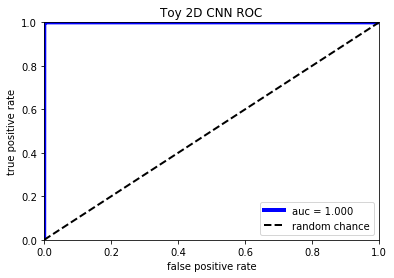

In [9]:
# Plot ROC
predict = best_model.predict(X_batch_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_batch_test[0][:][:,0], predict[:][:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=4, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Toy 2D CNN ROC')
plt.legend(loc="lower right")
plt.show()

In [10]:
#1D CNN WITH XAUG INPUTS

In [11]:
def build_xaug():
    input0 = layers.Input(name = 'pt_input', batch_shape=(None,batch, 1) )
    input1 = layers.Input(name = 'eta_input', batch_shape=(None,batch, 1) )
    input2 = layers.Input(name = 'phi_input', batch_shape=(None,batch, 1) )
    input3 = layers.Input(name = 'mass_input', batch_shape=(None,batch, 1) )
    x = layers.concatenate(inputs = [input0, input1, input2, input3],axis=-1, name = 'concat1')
    x = layers.Conv1D(64, 3, padding = 'same', activation='relu', name = 'conv1')(x)
    x = layers.Conv1D(64, 1, padding = 'same', activation='relu', name = 'conv2')(x)
    x = layers.MaxPool1D(2, name = "maxpool1")(x)
    x = layers.Conv1D(32, 3, padding = 'same', activation='relu', name = 'conv3')(x)
    x = layers.Conv1D(32, 1, padding = 'same', activation='relu', name = 'conv4')(x)
    x = layers.MaxPool1D(2, name = 'maxpool2')(x)
    x = layers.Flatten(name = 'flatten1')(x)
    input4 = layers.Input(batch_shape=(None,batch,), name = 'zinput')
    input5 = layers.Input(batch_shape=(None,batch,), name = 'rinput')
    input6 = layers.Input(batch_shape=(None,batch,), name = 'thetainput')
    x = layers.concatenate(inputs = [x, input4, input5, input6],axis=-1, name = 'concat2')
    x = layers.Dense(64, activation='relu', name = 'relu')(x)
    output = layers.Dense(2, activation='softmax', name = 'output')(x)  #switch to sigmoid
    model = models.Model(inputs=[input0, input1, input2, input3, input4, input5, input6], outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

In [14]:
features = [key for key in data_train.keys()];features.remove('labels');features
X_train, Y_train = build_XY(features,['labels'],data_train)
X_test, Y_test = build_XY(features,['labels'],data_test)
CNN_XAUG = build_xaug()

In [15]:
X_batch = [ele[:10] for ele in X_train]
Y_batch = [ele[:10] for ele in Y_train]
example_result = CNN_XAUG.predict(x = X_batch)
results = CNN_XAUG.evaluate(x = X_batch, y = Y_batch )
print(results)

10/10 [==============================] - 0s 12ms/step
[7.130660057067871, 7.130660057067871, 0.5]


In [16]:
X_batch = [ele for ele in X_train]
Y_batch = [ele for ele in Y_train]
X_batch_test = [ele for ele in X_test]
Y_batch_test = [ele for ele in Y_test]

In [17]:
checkpoint_path = "model/CNN1D_XAUG.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN_XAUG.fit(
  X_batch, Y_batch,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])


Epoch 00001: val_loss improved from inf to 0.02691, saving model to model/CNN1D_XAUG.h5

Epoch 00002: val_loss improved from 0.02691 to 0.00754, saving model to model/CNN1D_XAUG.h5

Epoch 00003: val_loss improved from 0.00754 to 0.00363, saving model to model/CNN1D_XAUG.h5

Epoch 00004: val_loss improved from 0.00363 to 0.00212, saving model to model/CNN1D_XAUG.h5

Epoch 00005: val_loss improved from 0.00212 to 0.00132, saving model to model/CNN1D_XAUG.h5

Epoch 00006: val_loss improved from 0.00132 to 0.00120, saving model to model/CNN1D_XAUG.h5

Epoch 00007: val_loss improved from 0.00120 to 0.00075, saving model to model/CNN1D_XAUG.h5

Epoch 00008: val_loss did not improve from 0.00075

Epoch 00009: val_loss improved from 0.00075 to 0.00040, saving model to model/CNN1D_XAUG.h5

Epoch 00010: val_loss improved from 0.00040 to 0.00038, saving model to model/CNN1D_XAUG.h5

Epoch 00011: val_loss did not improve from 0.00038

Epoch 00012: val_loss improved from 0.00038 to 0.00030, saving

In [18]:
best_model = keras.models.load_model('model/CNN1D_XAUG.h5')
best_model.summary()
results = best_model.evaluate(X_batch_test, Y_batch_test[0], verbose = 0)
print(X_batch_test[0])
print(results)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pt_input (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
eta_input (InputLayer)          (None, 10, 1)        0                                            
__________________________________________________________________________________________________
phi_input (InputLayer)          (None, 10, 1)        0                                            
__________________________________________________________________________________________________
mass_input (InputLayer)         (None, 10, 1)        0                                            
__________________________________________________________________________________________________
concat1 (C

In [19]:
# Plot ROC
predict = best_model.predict(X_batch_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_batch_test[0], predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=4, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Toy 2D CNN ROC')
plt.legend(loc="lower right")
plt.show()

ValueError: multilabel-indicator format is not supported

In [ ]:
sig_pred = predict[np.argwhere(Y_batch_test[0].squeeze()==1.)].squeeze()
bkg_pred = predict[np.argwhere(Y_batch_test[0].squeeze()==0.)].squeeze()
plt.hist([sig_pred, bkg_pred],
         color = ['blue', 'red'], histtype = 'step', label = ['signal predictions', 'background predictions'])
plt.legend()
plt.show()